In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-optimism-test"

def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()['data']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
fee_query = """
{ pools(first: 1000) {
  isV2
  id
  name
  dailyPoolSnapshots(first: 1000 orderBy: timestamp orderDirection: desc) {
    timestamp
    adminFeesUSD
    lpFeesUSD
    totalDailyFeesUSD
    eventFeesUSD
    baseApr
    tvl
  }
}
}
"""

In [3]:
data = grt_query(fee_query)['pools']
df = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df['totalDailyFeesUSD'] = df['totalDailyFeesUSD'].astype(float)
df['eventFeesUSD'] = df['eventFeesUSD'].astype(float) * 2
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values('timestamp', ascending=True)
df

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,tvl
336,False,0x1337bedc9d22ecbe766df105c9623922a27963ec,Curve.fi DAI/USDC/USDT,2022-01-17,0,0,0.00,0.00,0,15000.000202
335,False,0x1337bedc9d22ecbe766df105c9623922a27963ec,Curve.fi DAI/USDC/USDT,2022-01-18,1.821524209092986613166973493913829,1.821524209092986613166973493913829,3.64,0.00,0.00005788613609592358898509779914913249,31467.36562403342946579462975993915
334,False,0x1337bedc9d22ecbe766df105c9623922a27963ec,Curve.fi DAI/USDC/USDT,2022-01-19,80.53637727809931522578559202884415,80.53637727809931522578559202884415,161.07,0.00,0.000298302330045518491425311288498658,269982.3942568940843600455517346977
333,False,0x1337bedc9d22ecbe766df105c9623922a27963ec,Curve.fi DAI/USDC/USDT,2022-01-20,158.4436011642371232287491592183262,158.4436011642371232287491592183262,316.89,0.00,0.0002896284272819391981516250252147339,547058.1829662734652111791726915593
332,False,0x1337bedc9d22ecbe766df105c9623922a27963ec,Curve.fi DAI/USDC/USDT,2022-01-21,29.62378717112004866037208304035206,29.62378717112004866037208304035206,59.25,0.00,0.00005998162137216886507807492569948431,493881.0671240927687707862298707388
...,...,...,...,...,...,...,...,...,...,...
737,False,0x7c13f8fdbed6fa2dc567b2f7c85f116e0c5ab5c3,Curve.fi Factory Plain Pool: sLINK/LINK,2022-07-21,0,0,0.00,0.00,0,0
516,False,0x44a3e148fde06fb56cef741ceb886d37a25430b8,Curve.fi Factory USD Metapool: sUSD/CRV,2022-07-21,0,0,0.00,0.00,0,0
707,False,0x7bc5728bc2b59b45a58d9a576e2ffc5f0505b35e,Curve.fi Factory Pool: sETH/ETH,2022-07-21,0.3033113474781723377800884389809195,0.3033113474781723377800884389809195,0.61,0.00,0.000005988112231257819740329622593166783,50652.24828200338189034031732969862
349,False,0x309970d0cca31197620fedbedcd51bb46e2a73ba,Curve.fi Factory USD Metapool: LUSD,2022-07-21,0,0,0.00,0.00,0,0


<AxesSubplot:xlabel='timestamp'>

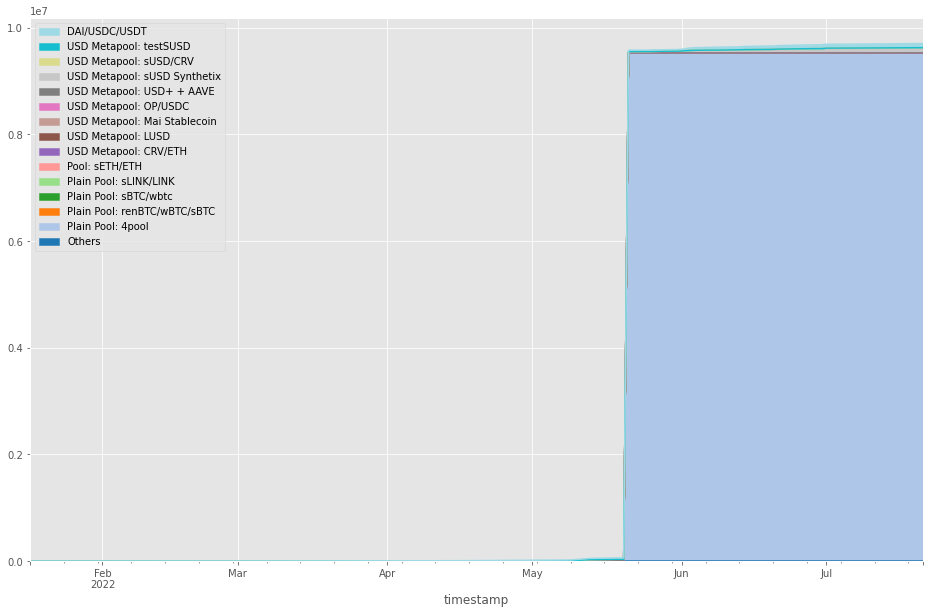

In [4]:
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data = df[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
top_performers = chart_data.mean().sort_values(ascending=False)[:19].index.tolist()
df_others = df.copy()
df_others['name'] = df_others['name'].apply(lambda x: x if x in top_performers else 'Others')
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data_others = df_others[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
chart_data_others['Others'] = df_others[df_others['name'] == 'Others'][['timestamp', 'cumulativeDailyFeesUSD']].groupby('timestamp').sum()['cumulativeDailyFeesUSD']
chart_data_others.columns = [s.replace('Curve.fi Factory ', '').replace('Curve.fi ', '').replace('Curve ', '') for s in chart_data_others.columns]
cols = chart_data_others.columns.tolist()
chart_data_others[([cols[-1], *cols[1:-1], cols[0]])].plot.area(figsize=(16, 10), legend='reverse', colormap="tab20")

In [5]:
WEEK = 3600 * 24 * 7
df_week = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df_week['totalDailyFeesUSD'] = df_week['totalDailyFeesUSD'].astype(float)
df_week['timestamp'] = df_week['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_week['timestamp'] = pd.to_datetime(df_week['timestamp'],unit='s')
df_week = df_week.sort_values('timestamp', ascending=True)
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum()

,totalDailyFeesUSD
timestamp,
2022-01-13,164.72
2022-01-20,650.14
2022-01-27,586.21
2022-02-03,283.24
2022-02-10,218.92
2022-02-17,433.87
2022-02-24,1383.20
2022-03-03,560.77
2022-03-10,442.51


In [6]:
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum().sum() / 2

totalDailyFeesUSD   4852089.61
dtype: float64